In [24]:
import numpy as np
import matplotlib.pyplot as plt
import helper_functions as hf
from helper_functions import setup
from helper_functions.classes.sport_event import SportEvent


In [12]:
df = setup.sanitize_and_anonymize_data(overwrite=True, anonymize=False)

sports = {sport: len(df[df[sport]]) for sport in hf.DATA_NOW.sport_events}
sports = sorted(sports.items(), key=lambda x: x[1], reverse=True)
num_paid = len(df[df["has_paid_fee"]])
print(f"{len(df)} entries ({num_paid} have paid) with the following distribution:\n\t{df["status"].value_counts().to_dict()}\n\t{df["institute"].value_counts().to_dict()}\n\t{sports}")

# print(",\n".join(df["nickname"].tolist()))

endings = [email.split("@")[1] if email != "???" else email for email in df["email"]]
print(len([end for end in endings if end == "???"]), "unknown email-addresses.")
# df.sort_values("num_sports", ascending=False)[["name", "num_sports"]].head(3)
# df["events_interested_in"].iloc[1]
# df[["volleyball", "ping_pong", "ping_pong_days"]]
# df[["name", "nickname", "institute"]].iloc[-30:]
# df[df["institute"].str.lower().str.contains("usm")]["name"]
# df[~df["has_paid_fee"]][["name", "institute"]].sort_values("institute")


[sports_week: WARNING] - Duplicate names (['DiYo']) found in payment info. Please check the file c:\Users\fabia\OneDrive\Dokumente\Freizeit\Programmieren\other\imprs_sports_week\scripts\..\data\2025\hidden\money_received.yml.
[sports_week: WARNING] - Found 4 people who managed to sign up multiple times. Keeping only  their latest entries.
186 entries (173 have paid) with the following distribution:
	{'PhD': 112, 'PostDoc': 44, 'Other': 18, "Master's Student": 12}
	{'MPE': 40, 'MPQ': 39, 'IPP': 29, 'MPA': 28, 'USM/LMU': 25, 'ESO': 12, 'MPP': 11, 'Other': 2}
	[('ping_pong', 75), ('volleyball', 67), ('beer_pong', 58), ('foosball', 55), ('football', 47), ('badminton', 47), ('capture_the_flag', 47), ('basketball', 34), ('spikeball', 31), ('running_sprints', 25), ('tennis', 22), ('chess', 21)]
0 unknown email-addresses.


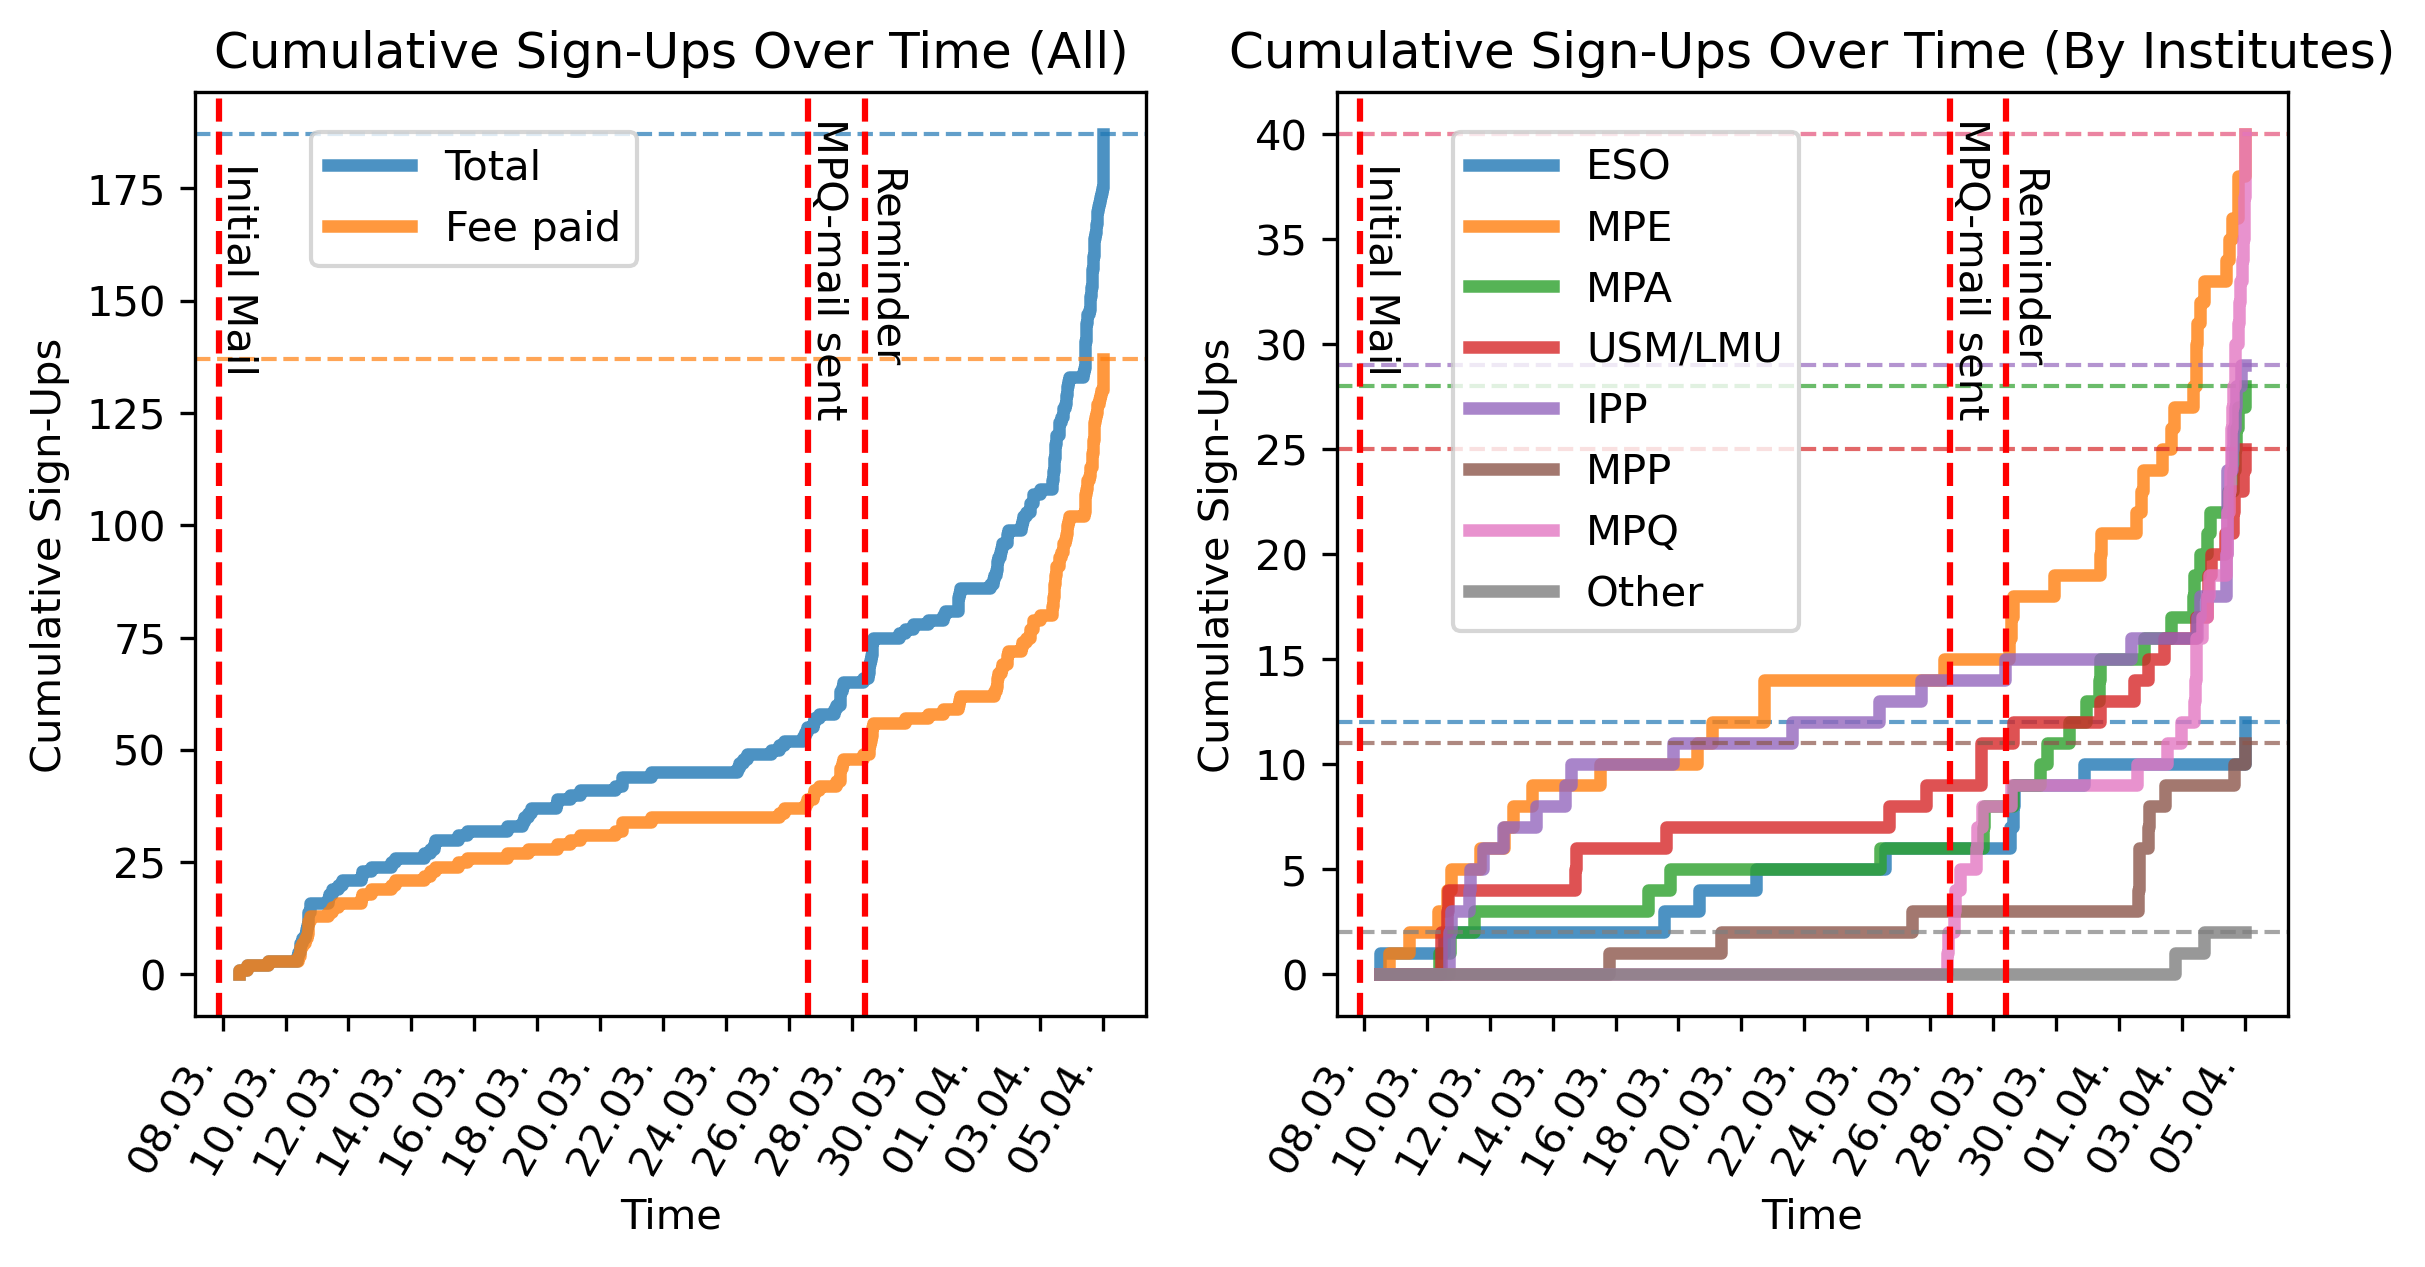

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.axes import Axes

MIN_TIME = pd.to_datetime(df["response_timestamp"]).min()
MAX_TIME = pd.to_datetime("2025-04-04 23:59:59")
def plot_cumulative_signups(data: pd.Series, label: str) -> None:
    data = pd.to_datetime(data).apply(lambda x: min(x, MAX_TIME))
    data = pd.concat([data, pd.Series(MIN_TIME), pd.Series(MAX_TIME)]).sort_values()
    cumulative_signups = list(range(0, len(data)))
    cumulative_signups[-1] -= 1 # The last entry is the max time, so we don't want to count it as a sign-up
    line, = plt.plot(data, cumulative_signups, marker="none", label=label, lw=3, alpha=0.8, drawstyle="steps-post")
    plt.axhline(y=len(data)-2, color=line.get_color(), linestyle="--", lw=1, alpha=0.7)

def _setup_plot():
    plt.xlabel("Time")
    plt.ylabel("Cumulative Sign-Ups")
    # plt.grid()
    plt.xticks(rotation=60)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m."))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=60, ha="right")
    plt.legend(fontsize=10, bbox_to_anchor=(0.1, 0.98), loc="upper left")

def _annotate_time(ax: Axes, time: str, label: str = ""):
    annotation_time = pd.to_datetime(time)
    ax.axvline(annotation_time, color="red", linestyle="--")
    ax.text(annotation_time, max(ax.get_ylim()) * 0.8, label, rotation=270, ha="left", va="center")

def _annotate_timestamps():
    _annotate_time(plt.gca(), "2025-03-07 21:00:00", "Initial Mail")
    _annotate_time(plt.gca(), "2025-03-26 15:00:00", "MPQ-mail sent")
    _annotate_time(plt.gca(), "2025-03-28 10:00:00", "Reminder")

fig, axes = plt.subplots(1, 2, figsize=(9, 4), dpi=300)
plt.sca(axes[0])
plt.title("Cumulative Sign-Ups Over Time (All)")
plot_cumulative_signups(df["response_timestamp"], "Total")
plot_cumulative_signups(df[df["has_paid_fee"]]["response_timestamp"], "Fee paid")
_setup_plot()
_annotate_timestamps()
plt.sca(axes[1])
plt.title("Cumulative Sign-Ups Over Time (By Institutes)")
for institute in df["institute"].unique():
    subdf = df[df["institute"] == institute]
    plot_cumulative_signups(subdf["response_timestamp"], institute)
_setup_plot()
_annotate_timestamps()


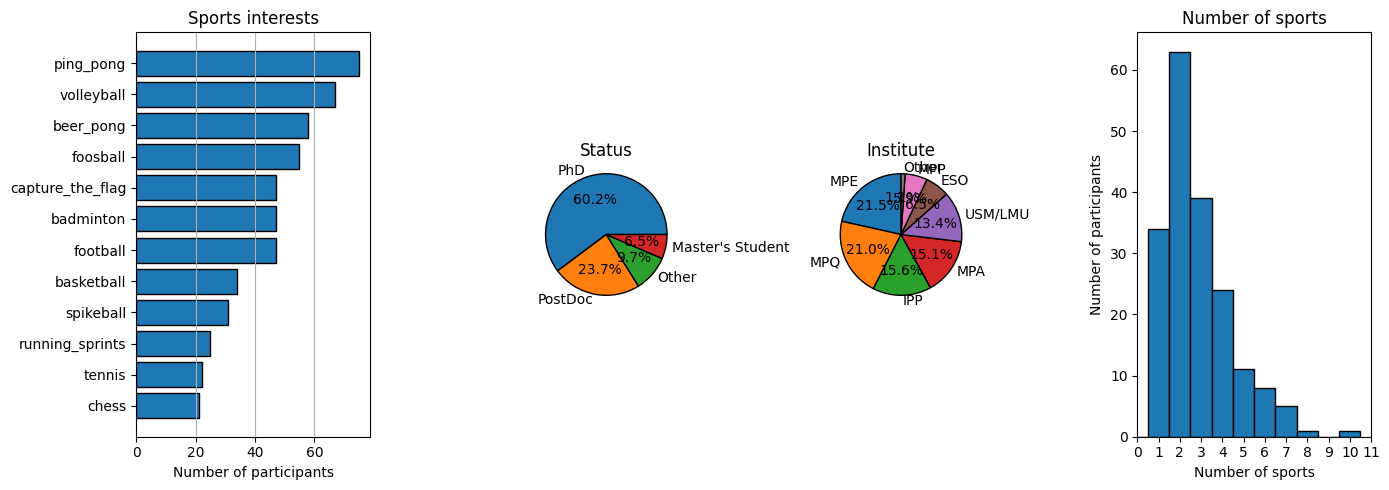

In [13]:
import pandas as pd
from matplotlib.axes import Axes
from matplotlib.ticker import MultipleLocator
from math import ceil
def _plot_sports_num(df: pd.DataFrame, ax: Axes):
    ax.hist(df["num_sports"], bins=np.arange(0, 12, 1), edgecolor="black", align="left")
    ax.set_title("Number of sports")
    ax.set_xlabel("Number of sports")
    ax.set_ylabel("Number of participants")
    ax.set_xlim(0, 11)
    ax.xaxis.set_major_locator(MultipleLocator(1))

def _plot_status_distribution(df: pd.DataFrame, ax: Axes):
    ax.pie(df["status"].value_counts().values,
           labels=df["status"].value_counts().index,
           autopct="%1.1f%%",
           wedgeprops=dict(edgecolor="black"),
           radius=1.3)
    ax.set_title("Status", y=1.1)
    ax.set_aspect("equal")

def _plot_institute_distribution(df: pd.DataFrame, ax: Axes):
    ax.pie(df["institute"].value_counts().values, labels=df["institute"].value_counts().index, autopct="%1.1f%%", wedgeprops=dict(edgecolor="black"), startangle=90, radius=1.3)
    ax.set_title("Institute", y=1.1)

def _plot_sports_interests(df: pd.DataFrame, ax: Axes, sports_list: list[str], **kwargs):
    sports = {sport: len(df[df[sport]]) for sport in sports_list}
    sports = sorted(sports.items(), key=lambda x: x[1], reverse=False)
    ax.barh([sport[0] for sport in sports], [sport[1] for sport in sports], edgecolor="black", **kwargs)
    ax.set_title("Sports interests")
    # ax.set_label("Sport")
    ax.set_xlabel("Number of participants")
    ax.grid(axis="x")
fig, axes = plt.subplots(1, 4, figsize=(14, 5), width_ratios=[2, 1, 1, 2])

df2 = hf.DATA_2024.players
_plot_sports_interests(df, axes[0], hf.DATA_NOW.sport_events.keys())
# _plot_sports_interests(df2, axes[0], hf.DATA_2024.sport_events.keys())
_plot_status_distribution(df, axes[1])
_plot_institute_distribution(df, axes[2])
_plot_sports_num(df, axes[3])
plt.subplots_adjust(wspace=0)
fig.tight_layout()


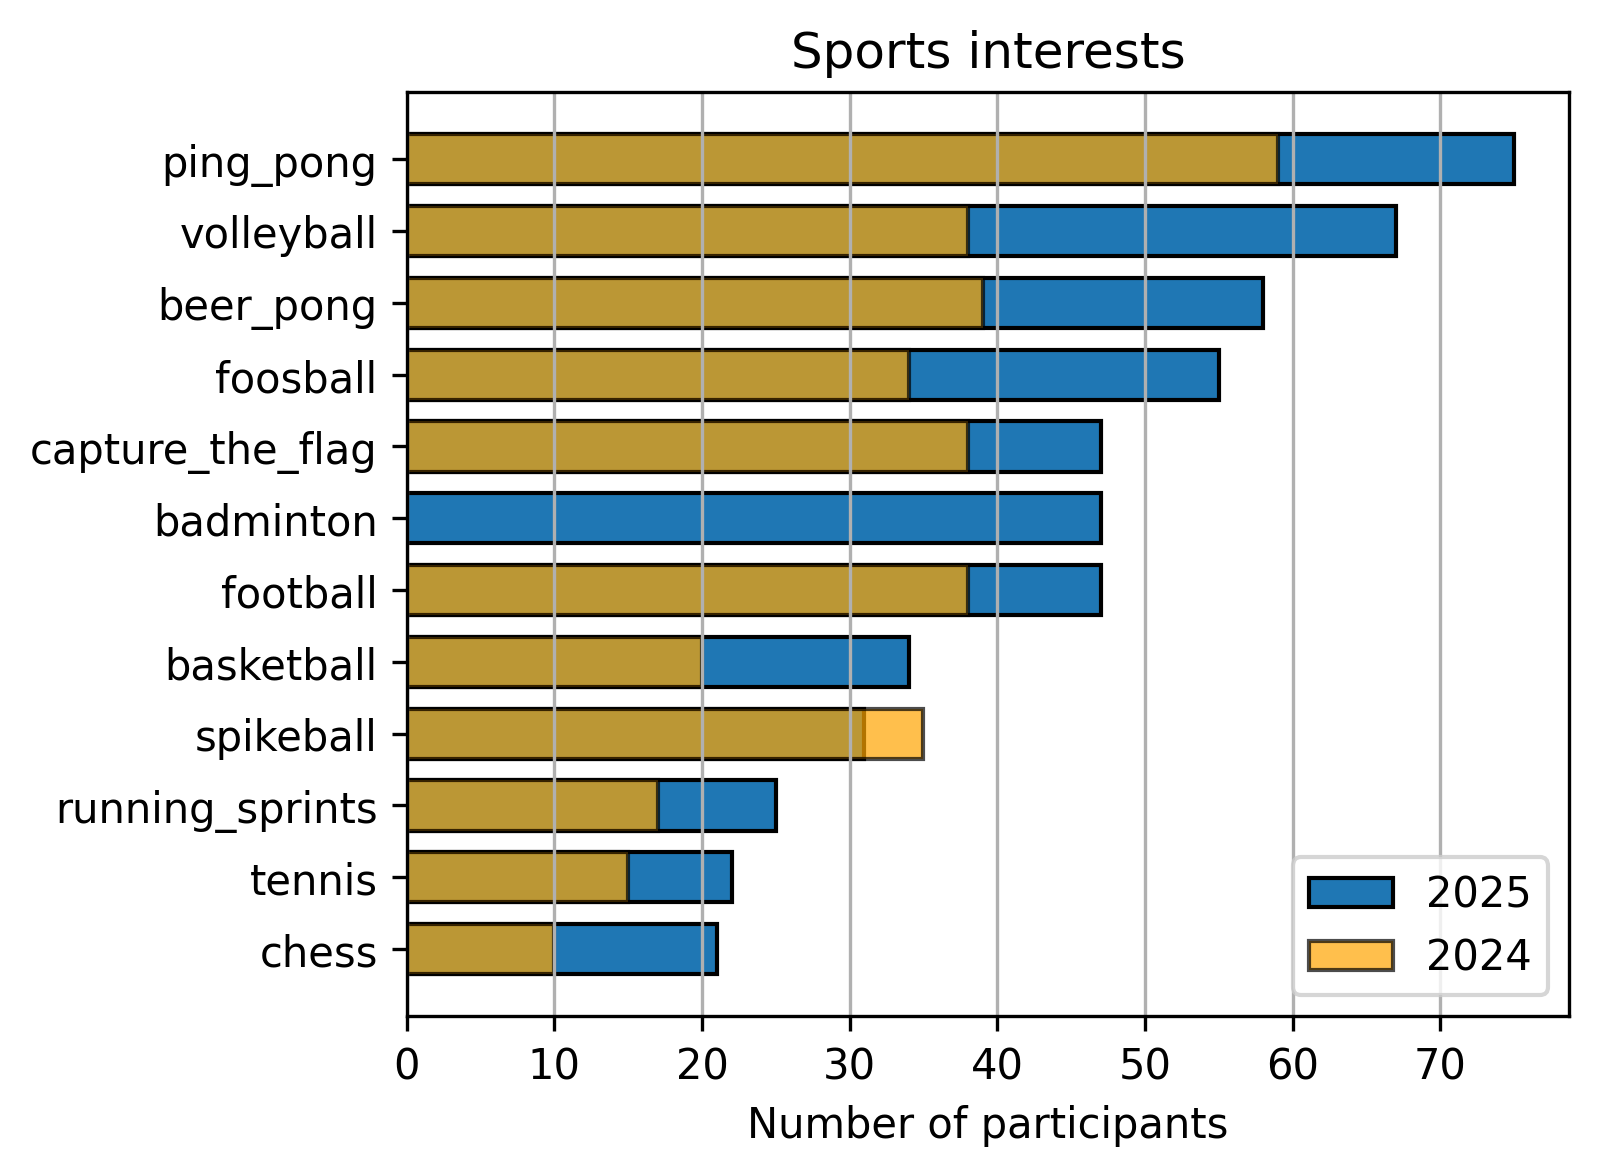

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
_plot_sports_interests(df, ax, hf.DATA_NOW.sport_events.keys(), height=0.7, label="2025")
_plot_sports_interests(df2, ax, hf.DATA_2024.sport_events.keys(), height=0.7, label="2024", color="orange", alpha=0.7)
ax.grid(axis="x")
plt.legend()



In [7]:
df["events_interested_in"].iloc[2]


'Volleyball - Monday 5th of May;Football  -  Tuesday 6th of May;Tennis - Tuesday 6th of May;Spikeball - Wednesday 7th of May;Capture the flag - Thursday 8th of May;Fooseball - Friday 9th of May;Ping Pong - Monday 5th of May (see note above);Ping Pong - Tuesday 6th of May;Ping Pong - Wednesday 7th of May;Ping Pong - Thursday 8th of May;Ping Pong - Friday 9th of May'